In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import h5py
from pylab import rcParams
import pandas as pd
rcParams['figure.figsize'] = 20,9

In [2]:
f = h5py.File('logs/predictions_default_normal.h5', 'r')

labels = np.array(f['labels'][:]).astype(int)
probs = np.array(f['probs']).astype(float)
mc_cosmics = np.array(f['rec.mc.cosmic']).astype(float)
vtx_stop = np.array(f['vtx_stop']).astype(float)
y_preds = np.argmax(probs, axis=1)
#pms=f['pm']


In [10]:
clases=['muon', 'electron', 'piminus']
predicciones = {'pdm': [], 'pde': [], 'pdp': [], 'label_true': [], 'predic': [], 'calificacion': [], 'p.pz': [],
                'p.E': [], 'nhitslc': [], 'vtx.x': [], 'vtx.y': [], 'vtx.z': [], 'stop.x': [], 'stop.y': [],
                'stop.z': [], 'euclidean': []}

for y_true, ypred, prob, mc_cosmic, vtxstop in zip(labels, y_preds, probs, mc_cosmics, vtx_stop):

    #predicciones['nombre'].append(fname)
    predicciones['pdm'].append(float(prob[0]))
    predicciones['pde'].append(float(prob[1]))
    predicciones['pdp'].append(float(prob[2]))

    predicciones['label_true'].append(clases[y_true])

    predicciones['predic'].append(clases[ypred])
    if (clases[y_true] == clases[ypred]):
        predicciones['calificacion'].append('T' + str(clases[y_true]))
    else:
        predicciones['calificacion'].append('F' + str(clases[ypred]))
    predicciones['p.pz'].append(float(mc_cosmic[0]))
    predicciones['p.E'].append(float(mc_cosmic[1]))
    predicciones['nhitslc'].append(float(mc_cosmic[2]))
    predicciones['vtx.x'].append(float(vtxstop[0]))
    predicciones['vtx.y'].append(float(vtxstop[1]))
    predicciones['vtx.z'].append(float(vtxstop[2]))
    predicciones['stop.x'].append(float(vtxstop[3]))
    predicciones['stop.y'].append(float(vtxstop[4]))
    predicciones['stop.z'].append(float(vtxstop[5]))
    predicciones['euclidean'].append(float(np.sqrt(np.sum(
        np.square(np.array((vtxstop[0], vtxstop[1], vtxstop[2])) - np.array((vtxstop[3], vtxstop[4], vtxstop[5],)))))))
dfpred = pd.DataFrame(data=predicciones)


In [11]:
dfpred

,pdm,pde,pdp,label_true,predic,calificacion,p.pz,p.E,nhitslc,vtx.x,vtx.y,vtx.z,stop.x,stop.y,stop.z,euclidean
0,0.833376,0.047081,0.119543,muon,muon,Tmuon,0.272577,0.579297,37.0,143.186356,-89.492485,166.084915,-36.968513,-48.432026,288.827301,221.827481
1,0.000007,0.999903,0.000089,electron,electron,Telectron,2.724719,3.552066,100.0,-170.562744,68.525818,253.259140,-153.211441,14.885431,329.200836,94.580653
2,0.000034,0.999706,0.000259,electron,electron,Telectron,-0.355085,3.474192,102.0,123.588921,-173.124908,511.450348,101.322456,-147.458694,514.452637,34.111050
3,0.000011,0.002612,0.997377,piminus,piminus,Tpiminus,0.202783,2.308710,95.0,140.538620,-36.102127,499.904755,113.289902,-27.878859,502.326172,28.565330
4,0.000002,0.001382,0.998615,piminus,piminus,Tpiminus,0.323577,0.450152,17.0,79.001381,55.749084,583.918091,70.061668,60.399086,595.807739,15.585401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24877,0.001368,0.020208,0.978424,piminus,piminus,Tpiminus,0.193164,0.417360,23.0,-110.511490,9.688830,276.842590,-172.514313,-64.473236,334.273956,112.439868
24878,0.000017,0.999828,0.000156,electron,electron,Telectron,-1.255876,2.753900,76.0,54.562927,109.849953,630.807251,-19.754131,101.431793,594.477600,83.148867
24879,0.754773,0.098739,0.146488,muon,muon,Tmuon,0.136458,0.195418,5.0,-174.077774,-19.307804,332.521454,-160.247208,-18.000538,356.364227,27.594770
24880,0.080301,0.861840,0.057858,electron,electron,Telectron,-0.219763,0.630924,29.0,11.586881,-165.225647,352.590668,2.373121,-102.068787,313.946564,74.612661


In [19]:
dfpred=dfpred[dfpred['label_true']=='muon']
dfpred=dfpred[dfpred['nhitslc']>100]
dfpred=dfpred[dfpred['pdm']<0.3]
dfpred

,pdm,pde,pdp,label_true,predic,calificacion,p.pz,p.E,nhitslc,vtx.x,vtx.y,vtx.z,stop.x,stop.y,stop.z,euclidean
265,0.081713,0.103217,0.815070,muon,piminus,Fpiminus,1.381328,1.513466,104.0,133.061401,155.815720,374.666504,-113.837448,68.705109,990.409790,669.094235
1896,0.203421,0.692442,0.104138,muon,electron,Felectron,1.045696,1.280964,105.0,-50.907135,-38.451077,405.269379,179.230194,179.256393,873.616760,565.428159
18657,0.285728,0.588325,0.125947,muon,electron,Felectron,1.887541,1.927808,123.0,132.583862,77.951523,319.010529,9.445786,-108.488838,1121.540527,833.053055


/tmp/ipykernel_25303/3611668117.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


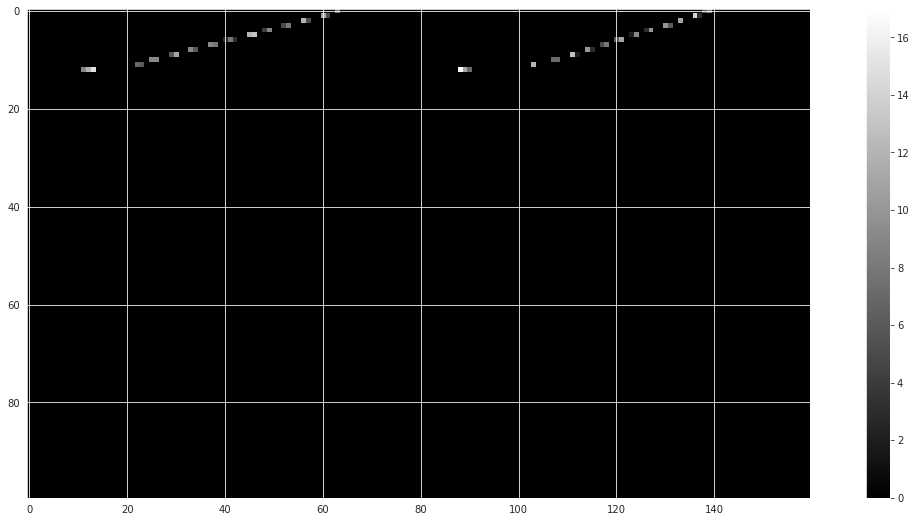

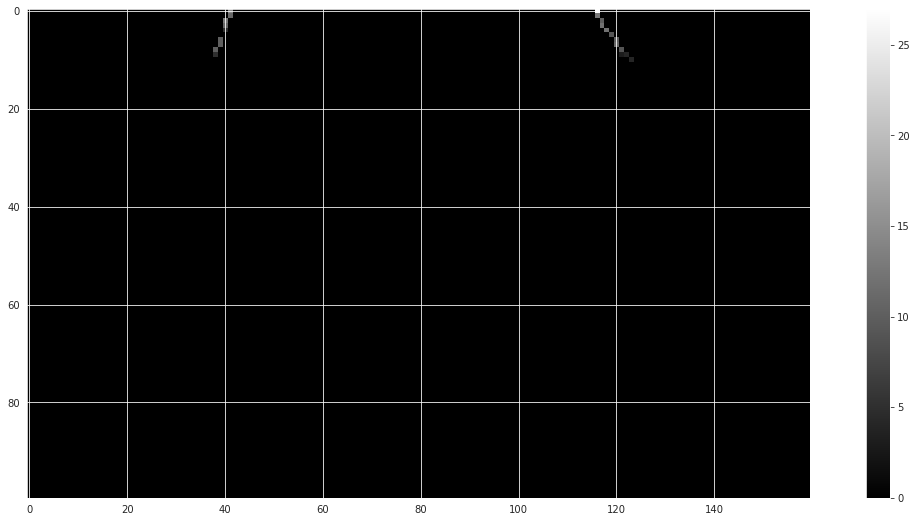

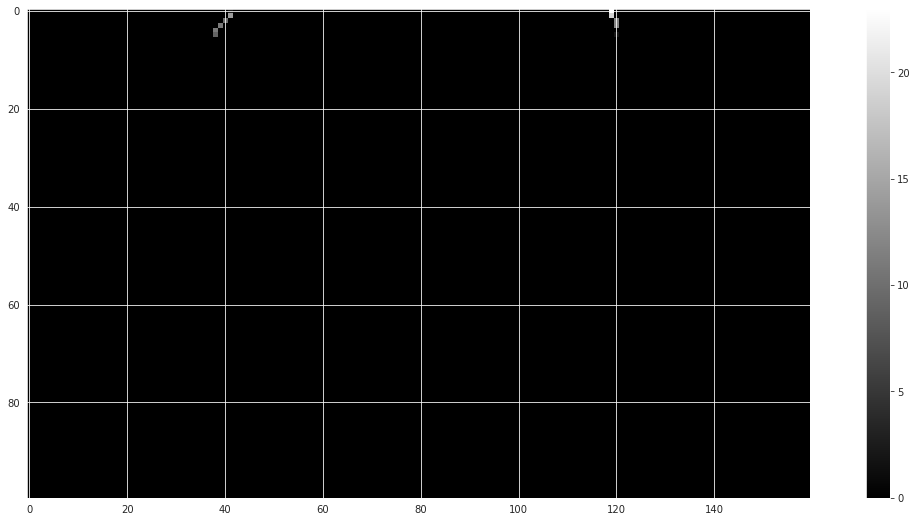

In [21]:
for i in dfpred.index:
    pm=f['pm'][i]
    pm=pm.reshape((2,100,80,1))
    pm=np.concatenate((pm[0].reshape((100,80)),pm[1].reshape((100,80))),axis = 1)
    pm = np.stack((pm,)*3, axis=-1)
    max=np.max(pm)
    pm= pm /max
    plt.imshow(pm,cmap='gray',vmin=0, vmax=max)
    plt.colorbar()
    plt.show()
    img = im.fromarray((pm * 255).astype(np.uint8))
    img.save('pm.jpg')

In [4]:
print(max(f['pm'][0]))

40


In [5]:
ma=0
for pm in f['pm']:
    if(ma<max(pm)):
        ma=max(pm)
        print('el maximo ahora es ',ma)

el maximo ahora es  40
el maximo ahora es  80
el maximo ahora es  93
el maximo ahora es  99
el maximo ahora es  109
el maximo ahora es  116
el maximo ahora es  145
el maximo ahora es  147
el maximo ahora es  162
el maximo ahora es  163
